Images model

In [71]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
DATASET_PATH = "/content/drive/MyDrive/ML dataset/Images"

CLASSES = {
    "Small damage": 0,
    "Moderate damage": 1,
    "High damage": 2
}

IMAGE_SIZE = (64, 64)


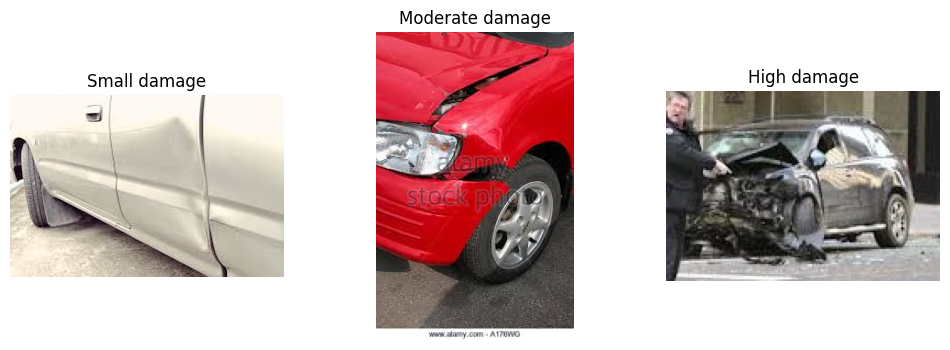

In [73]:
plt.figure(figsize=(12,4))

for i, class_name in enumerate(CLASSES.keys()):
    class_path = os.path.join(DATASET_PATH, class_name)
    sample_img = os.listdir(class_path)[0]  # أول صورة لكل class
    img = Image.open(os.path.join(class_path, sample_img))

    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.show()


In [74]:
X_hog = []
y_hog = []

for class_name, label in CLASSES.items():
    class_path = os.path.join(DATASET_PATH, class_name)
    for img_name in tqdm(os.listdir(class_path), desc=class_name):
        img_path = os.path.join(class_path, img_name)
        try:
            img = Image.open(img_path).convert("L")
            img = img.resize(IMAGE_SIZE)
            img_array = np.array(img)/255.0

            if np.isnan(img_array).any():
                continue

            features, _ = hog(
                img_array,
                orientations=9,
                pixels_per_cell=(8,8),
                cells_per_block=(2,2),
                block_norm='L2-Hys',
                visualize=True
            )

            X_hog.append(features)
            y_hog.append(label)
        except:
            continue

X_hog = np.array(X_hog)
y_hog = np.array(y_hog)

print("HOG X shape:", X_hog.shape)
print("HOG y shape:", y_hog.shape)

np.save("X_hog_images.npy", X_hog)
np.save("y_hog_images.npy", y_hog)


High damage: 100%|██████████| 559/559 [00:13<00:00, 40.77it/s]

HOG X shape: (1631, 1764)
HOG y shape: (1631,)


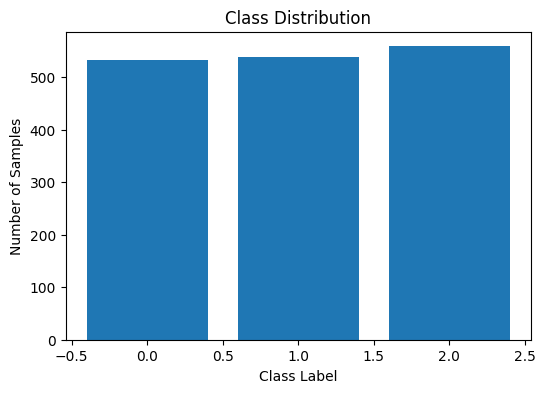

In [75]:
import matplotlib.pyplot as plt
import numpy as np

labels, counts = np.unique(y_hog, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar(labels, counts)
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.show()


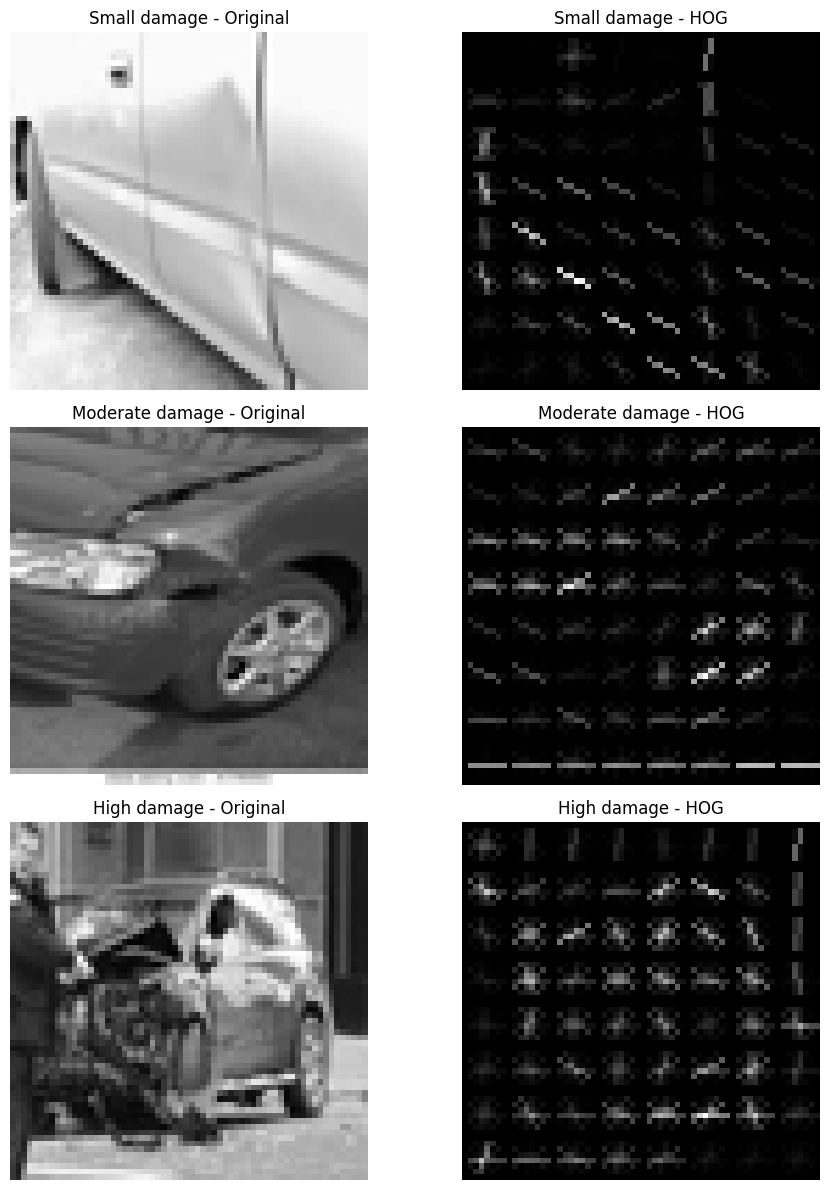

In [76]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from PIL import Image
import numpy as np
import os

plt.figure(figsize=(10, 12))
i = 1

for class_name, label in CLASSES.items():
    class_path = os.path.join(DATASET_PATH, class_name)

    # خُد أول صورة من كل class
    img_name = os.listdir(class_path)[0]
    img_path = os.path.join(class_path, img_name)

    img = Image.open(img_path).convert("L")
    img = img.resize(IMAGE_SIZE)
    img_array = np.array(img) / 255.0

    features, hog_image = hog(
        img_array,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=True
    )

    # Original Image
    plt.subplot(3, 2, i)
    plt.imshow(img_array, cmap='gray')
    plt.title(f"{class_name} - Original")
    plt.axis("off")

    # HOG Image
    plt.subplot(3, 2, i + 1)
    plt.imshow(hog_image, cmap='gray')
    plt.title(f"{class_name} - HOG")
    plt.axis("off")

    i += 2

plt.tight_layout()
plt.show()


In [77]:
X_img, y_img = X_hog, y_hog

X_img_train, X_img_temp, y_img_train, y_img_temp = train_test_split(
    X_img, y_img, test_size=0.3, random_state=42, stratify=y_img
)

X_img_val, X_img_test, y_img_val, y_img_test = train_test_split(
    X_img_temp, y_img_temp, test_size=0.5, random_state=42, stratify=y_img_temp
)

print("Train shape:", X_img_train.shape)
print("Val shape:", X_img_val.shape)
print("Test shape:", X_img_test.shape)


Train shape: (1141, 1764)
Val shape: (245, 1764)
Test shape: (245, 1764)


In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()

X_img_train_scaled = scaler.fit_transform(X_img_train)
X_img_val_scaled   = scaler.transform(X_img_val)
X_img_test_scaled  = scaler.transform(X_img_test)

pca = PCA(n_components=100, whiten=True, random_state=42)

X_img_train_pca = pca.fit_transform(X_img_train_scaled)
X_img_val_pca   = pca.transform(X_img_val_scaled)
X_img_test_pca  = pca.transform(X_img_test_scaled)

print("Train PCA shape:", X_img_train_pca.shape)
print("Val PCA shape:",   X_img_val_pca.shape)
print("Test PCA shape:",  X_img_test_pca.shape)



Train PCA shape: (1141, 100)
Val PCA shape: (245, 100)
Test PCA shape: (245, 100)


In [79]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(
    penalty='l2',  # ممكن تجرب 'l1' لو حابب
    C=0.01,
    dual=False,
    max_iter=5000,
    random_state=42
)

svm_model.fit(X_img_train_pca, y_img_train)

train_img_acc = svm_model.score(X_img_train_pca, y_img_train)
val_img_acc   = svm_model.score(X_img_val_pca, y_img_val)
test_img_acc  = svm_model.score(X_img_test_pca, y_img_test)

print("Train Accuracy:", train_img_acc)
print("Validation Accuracy:", val_img_acc)
print("Test Accuracy:", test_img_acc)


Train Accuracy: 0.6415425065731815
Validation Accuracy: 0.5714285714285714
Test Accuracy: 0.5387755102040817


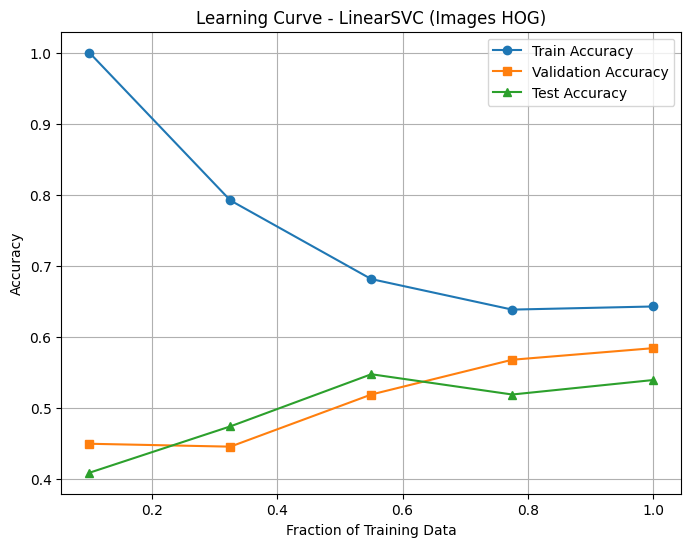

In [80]:
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC

# Shuffle
X_train_sample, y_train_sample = shuffle(
    X_img_train_pca, y_img_train, random_state=42
)

train_sizes = np.linspace(0.1, 1.0, 5)

train_scores = []
val_scores   = []
test_scores  = []

for frac in train_sizes:
    n = int(len(X_train_sample) * frac)

    X_sub = X_train_sample[:n]
    y_sub = y_train_sample[:n]

    model = LinearSVC(
        penalty='l2',
        C=1.0,
        dual=False,
        max_iter=5000,
        random_state=42
    )

    model.fit(X_sub, y_sub)

    # Train / Val / Test accuracy
    train_scores.append(model.score(X_sub, y_sub))
    val_scores.append(model.score(X_img_val_pca, y_img_val))
    test_scores.append(model.score(X_img_test_pca, y_img_test))

# Plot
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores, 'o-', label='Train Accuracy')
plt.plot(train_sizes, val_scores, 's-', label='Validation Accuracy')
plt.plot(train_sizes, test_scores, '^-', label='Test Accuracy')

plt.xlabel("Fraction of Training Data")
plt.ylabel("Accuracy")
plt.title("Learning Curve - LinearSVC (Images HOG)")
plt.legend()
plt.grid(True)
plt.show()


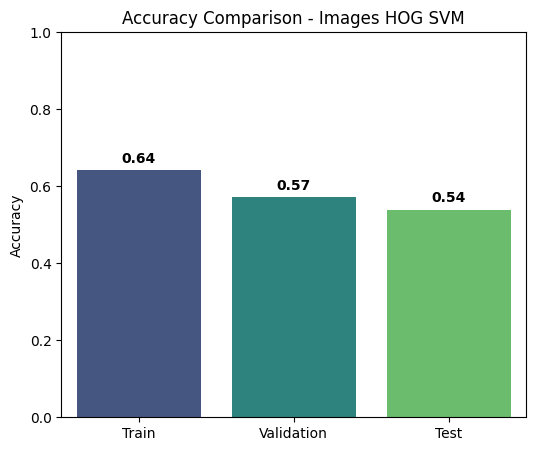

In [81]:
acc_values = [train_img_acc, val_img_acc, test_img_acc]
labels = ['Train', 'Validation', 'Test']

plt.figure(figsize=(6,5))
sns.barplot(x=labels, y=acc_values, palette="viridis")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison - Images HOG SVM")
for i, v in enumerate(acc_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()


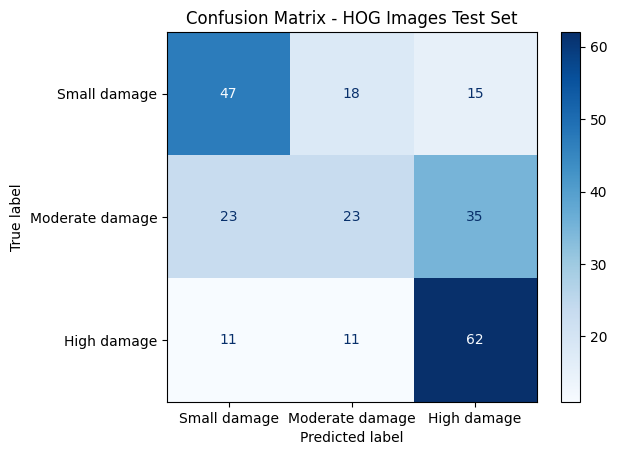

In [82]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict
y_img_pred = svm_model.predict(X_img_test_pca)

# Confusion Matrix
cm = confusion_matrix(y_img_test, y_img_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)  # list مباشرة
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix - HOG Images Test Set")
plt.show()



Audio Model


In [83]:
!pip install librosa soundfile pydub

In [84]:
import os, time, json
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import joblib
import warnings
warnings.filterwarnings('ignore')

BASE_PATH = '/content/drive/MyDrive/ML dataset'
AUDIO_PATH = os.path.join(BASE_PATH, 'Audio')
PREPROCESS_PATH = os.path.join(BASE_PATH, 'preprocessed_audio')
CLASSES = ['Engine Issue', 'Non engine issue', 'Normal engine']
os.makedirs(PREPROCESS_PATH, exist_ok=True)


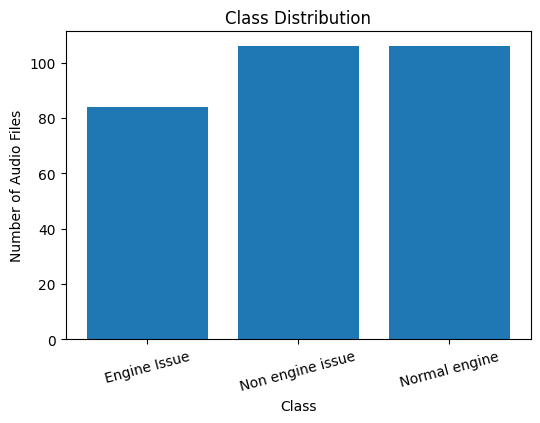

In [85]:
import os
import matplotlib.pyplot as plt

class_counts = []

for cls in CLASSES:
    cls_path = os.path.join(AUDIO_PATH, cls)
    class_counts.append(len(os.listdir(cls_path)))

plt.figure(figsize=(6,4))
plt.bar(CLASSES, class_counts)
plt.xlabel("Class")
plt.ylabel("Number of Audio Files")
plt.title("Class Distribution")
plt.xticks(rotation=15)
plt.show()


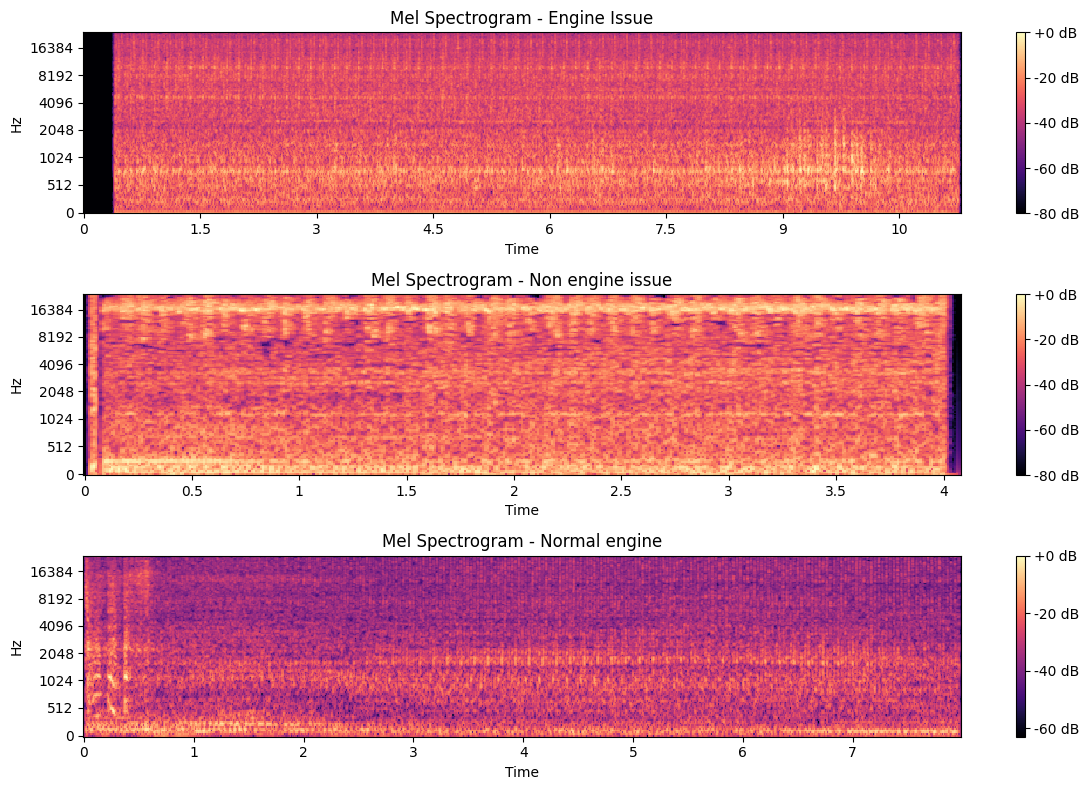

In [86]:
plt.figure(figsize=(12,8))
i = 1

for cls in CLASSES:
    cls_path = os.path.join(AUDIO_PATH, cls)
    audio_file = os.listdir(cls_path)[0]
    audio_path = os.path.join(cls_path, audio_file)

    y, sr = librosa.load(audio_path, sr=None)

    mel = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=128,
        fmax=8000
    )

    mel_db = librosa.power_to_db(mel, ref=np.max)

    plt.subplot(3,1,i)
    librosa.display.specshow(
        mel_db,
        sr=sr,
        x_axis='time',
        y_axis='mel'
    )
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram - {cls}")

    i += 1

plt.tight_layout()
plt.show()


In [87]:
def list_audio_files(audio_path, classes=CLASSES):
    data = []
    for idx, cls in enumerate(classes):
        cls_path = os.path.join(audio_path, cls)
        files = [f for f in os.listdir(cls_path) if f.endswith(('.wav','.mp3','.flac','.ogg'))]
        for f in files:
            data.append({'file': os.path.join(cls_path,f), 'label': idx, 'label_name': cls})
    return data

def preprocess_audio(audio, sr, target_sr=22050, duration=5.0):
    if sr != target_sr:
        audio = librosa.resample(y=audio, orig_sr=sr, target_sr=target_sr)
    audio = librosa.util.normalize(audio)
    target_len = int(target_sr*duration)
    if len(audio)<target_len: audio = np.pad(audio,(0,target_len-len(audio)))
    else: audio = audio[:target_len]
    return audio, target_sr

def extract_features(audio, sr):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    mel = librosa.feature.melspectrogram(y=audio, sr=sr)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y=audio)

    feats = np.hstack([
        np.mean(mfccs,1), np.std(mfccs,1),
        np.mean(mel,1), np.std(mel,1),
        np.mean(chroma,1), np.std(chroma,1),
        np.mean(contrast,1),
        np.mean(zcr), np.std(zcr)
    ])
    return feats

def process_dataset(audio_path):
    dataset = list_audio_files(audio_path)
    X, y = [], []
    for item in dataset:
        audio, sr = librosa.load(item['file'], sr=None)
        audio, sr = preprocess_audio(audio, sr)
        feats = extract_features(audio, sr)
        X.append(feats)
        y.append(item['label'])
    return np.array(X), np.array(y)

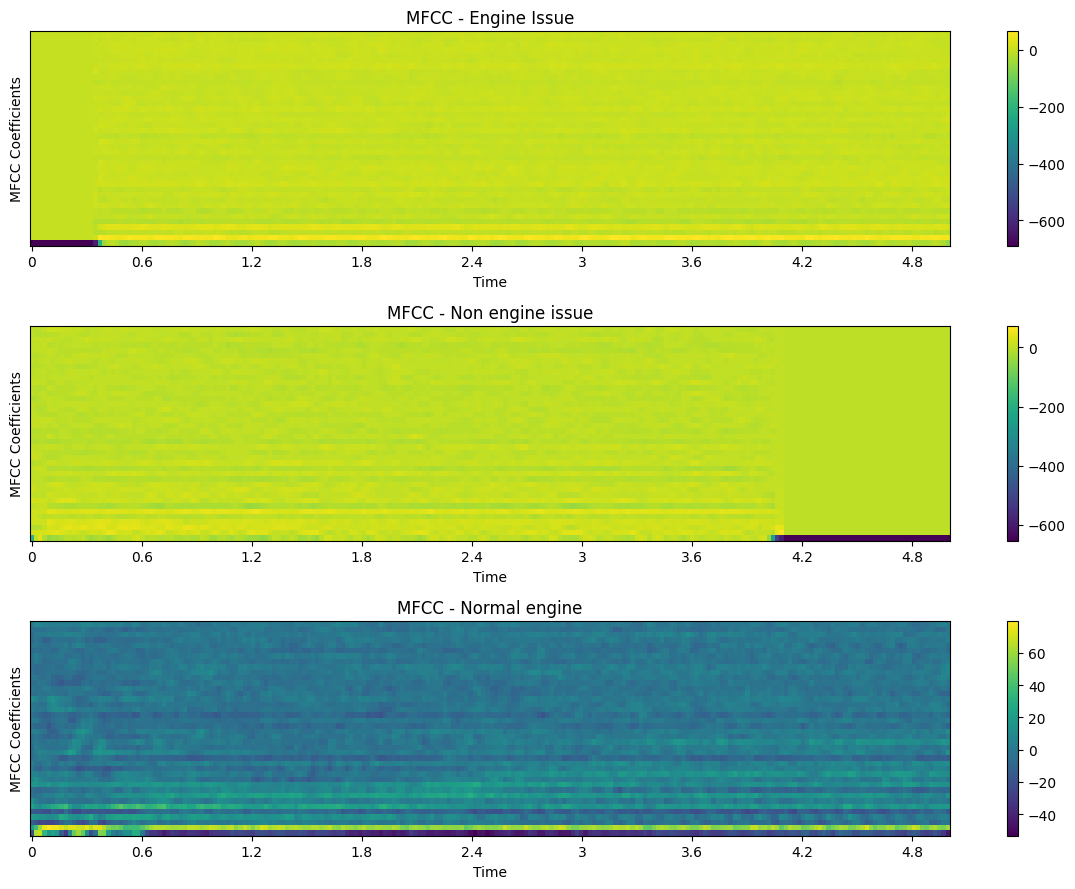

In [88]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import os

plt.figure(figsize=(12, 9))
i = 1

for cls in CLASSES:
    cls_path = os.path.join(AUDIO_PATH, cls)
    audio_file = os.listdir(cls_path)[0]
    audio_path = os.path.join(cls_path, audio_file)

    y, sr = librosa.load(audio_path, sr=None)
    y, sr = preprocess_audio(y, sr)

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

    plt.subplot(3, 1, i)
    librosa.display.specshow(
        mfccs,
        x_axis='time',
        sr=sr,
        cmap='viridis'
    )
    plt.colorbar()
    plt.title(f"MFCC - {cls}")
    plt.ylabel("MFCC Coefficients")

    i += 1

plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

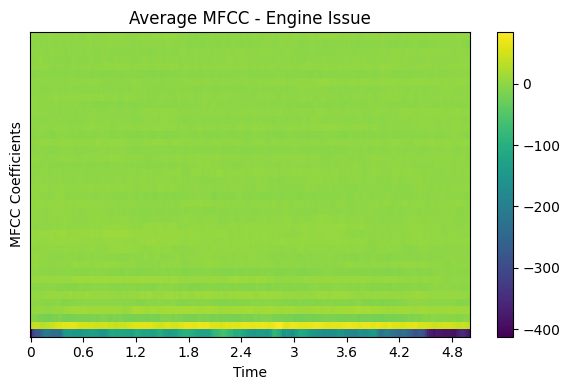

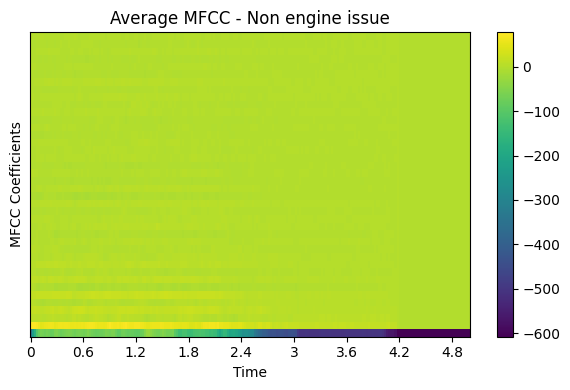

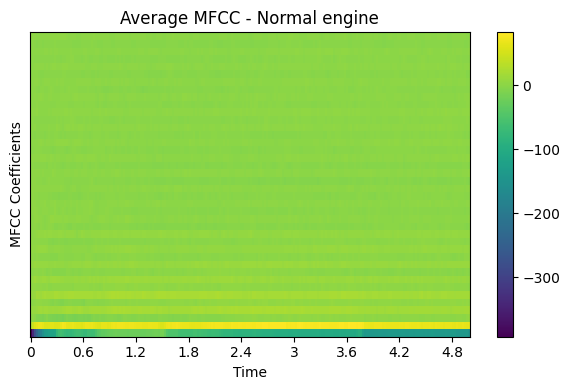

In [89]:
plt.figure(figsize=(12, 6))

for cls in CLASSES:
    cls_path = os.path.join(AUDIO_PATH, cls)
    files = os.listdir(cls_path)

    mfcc_list = []

    for f in files[:10]:  # خد 10 ملفات بس (كفاية visualization)
        y, sr = librosa.load(os.path.join(cls_path, f), sr=None)
        y, sr = preprocess_audio(y, sr)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfcc_list.append(mfccs)

    avg_mfcc = np.mean(mfcc_list, axis=0)

    plt.figure(figsize=(6,4))
    librosa.display.specshow(
        avg_mfcc,
        x_axis='time',
        sr=sr,
        cmap='viridis'
    )
    plt.colorbar()
    plt.title(f"Average MFCC - {cls}")
    plt.ylabel("MFCC Coefficients")
    plt.tight_layout()
    plt.show()


In [90]:
# ==========================================
# LOAD & PROCESS DATA
# ==========================================
X, y = process_dataset(AUDIO_PATH)

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, os.path.join(PREPROCESS_PATH,'scaler.pkl'))

# Apply PCA
pca = PCA(n_components=50, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)
joblib.dump(pca, os.path.join(PREPROCESS_PATH,'pca.pkl'))

print(f"Dataset shapes after PCA: Train={X_train_pca.shape}, Val={X_val_pca.shape}, Test={X_test_pca.shape}")


Dataset shapes after PCA: Train=(207, 50), Val=(44, 50), Test=(45, 50)


In [91]:
# ==========================================
# LOGISTIC REGRESSION WITH REGULARIZATION
# ==========================================
logreg = LogisticRegression(penalty='l2', C=0.01, max_iter=5000, solver='lbfgs')
start = time.time()
logreg.fit(X_train_pca, y_train)
print(f"Training time: {time.time()-start:.2f} sec")
joblib.dump(logreg, os.path.join(PREPROCESS_PATH,'logreg_model.pkl'))

# Predictions
y_train_pred = logreg.predict(X_train_pca)
y_val_pred = logreg.predict(X_val_pca)
y_test_pred = logreg.predict(X_test_pca)

# Accuracy Scores
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\nAccuracy:\n  Train: {train_acc*100:.2f}%\n  Validation: {val_acc*100:.2f}%\n  Test: {test_acc*100:.2f}%")

Training time: 0.03 sec

Accuracy:
  Train: 75.36%
  Validation: 61.36%
  Test: 62.22%


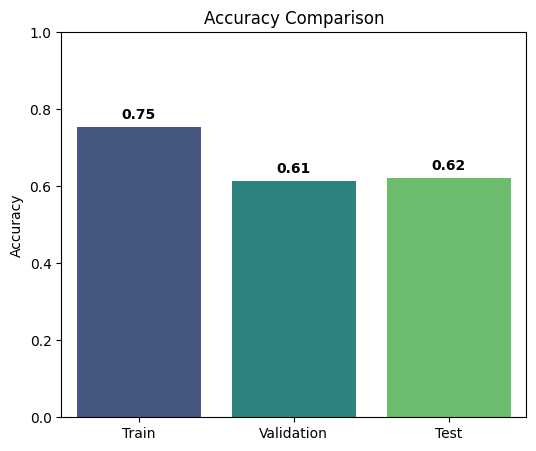

In [92]:
# ==========================================
# Accuracy Comparison Bar Chart
# ==========================================
acc_values = [train_acc, val_acc, test_acc]
labels = ['Train', 'Validation', 'Test']

plt.figure(figsize=(6,5))
sns.barplot(x=labels, y=acc_values, palette="viridis")
plt.ylim(0,1)
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
for i, v in enumerate(acc_values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()


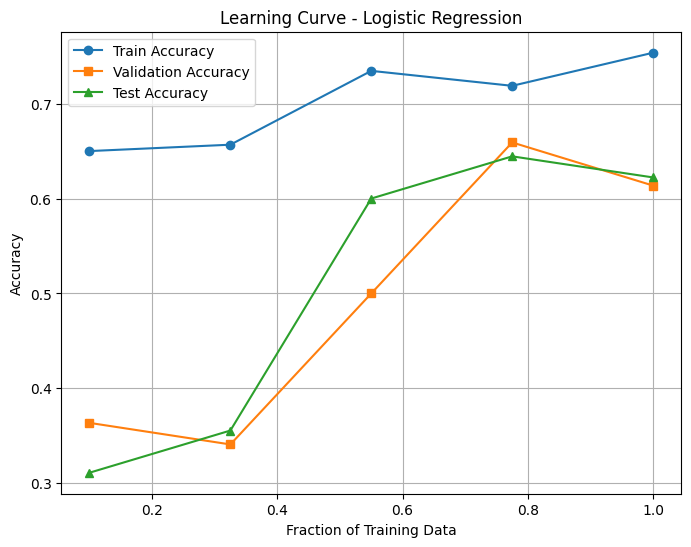

In [93]:
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt

# Shuffle training data
X_train_sample, y_train_sample = shuffle(X_train_pca, y_train, random_state=42)

# Define fractions of training data
train_sizes = np.linspace(0.1, 1.0, 5)

train_scores = []
val_scores = []
test_scores = []

# Loop over fractions
for frac in train_sizes:
    n = int(len(X_train_sample) * frac)
    X_sub = X_train_sample[:n]
    y_sub = y_train_sample[:n]

    # Train Logistic Regression
    model = LogisticRegression(penalty='l2', C=0.01, max_iter=5000, solver='lbfgs')
    model.fit(X_sub, y_sub)

    # Evaluate
    train_scores.append(model.score(X_sub, y_sub))
    val_scores.append(model.score(X_val_pca, y_val))
    test_scores.append(model.score(X_test_pca, y_test))

# Plot Learning Curve
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores, 'o-', label='Train Accuracy')
plt.plot(train_sizes, val_scores, 's-', label='Validation Accuracy')
plt.plot(train_sizes, test_scores, '^-', label='Test Accuracy')

plt.xlabel("Fraction of Training Data")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


                  precision    recall  f1-score   support

    Engine Issue       0.67      0.46      0.55        13
Non engine issue       0.69      0.69      0.69        16
   Normal engine       0.55      0.69      0.61        16

        accuracy                           0.62        45
       macro avg       0.63      0.61      0.61        45
    weighted avg       0.63      0.62      0.62        45



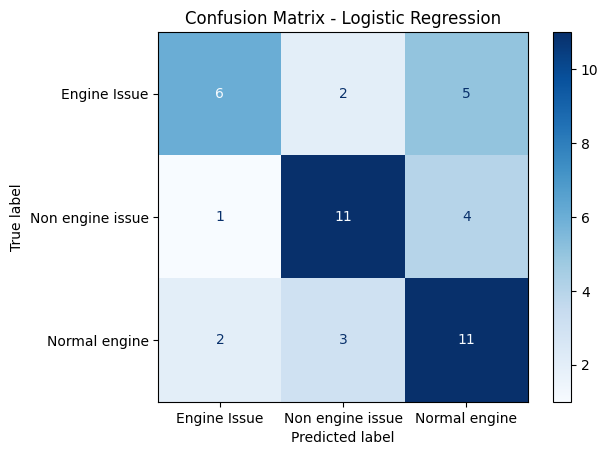

In [94]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# تأكد من ترتيب CLASSES مطابق للترميز
CLASSES = ['Engine Issue', 'Non engine issue', 'Normal engine']

# Classification report
print(classification_report(y_test, y_test_pred, target_names=CLASSES))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)

# Plot
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()



MULTIMODAL


In [104]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np
import joblib

# =============================
# Assume X_img_train_pca, X_img_test_pca, y_img_train
# X_train_pca, X_test_pca, y_train (audio) are ready
# =============================

# -----------------------------
# Train Image Model (HOG features)
# -----------------------------
image_model = LinearSVC(max_iter=5000, random_state=42)
image_model.fit(X_img_train_pca, y_img_train)

# -----------------------------
# Train Audio Model (MFCC features)
# -----------------------------
audio_model = LogisticRegression(max_iter=5000, random_state=42)
audio_model.fit(X_train_pca, y_train)

# -----------------------------
# Predictions
# -----------------------------
pred_image = image_model.predict(X_img_test_pca)  # numerical labels
pred_audio = audio_model.predict(X_test_pca)     # numerical labels

# -----------------------------
# Convert numerical labels to names
# -----------------------------
image_classes = ['High Damage', 'Moderate Damage', 'Low Damage']
audio_classes = ['Engine Issue', 'Non Engine Issue', 'Normal engine']

pred_image_names = [image_classes[i] for i in pred_image]
pred_audio_names = [audio_classes[i] for i in pred_audio]

# -----------------------------
# Mapping for Late Fusion
# -----------------------------
mapping = {
    ('High Damage', 'Engine Issue'): 'Huge Problem',
    ('High Damage', 'Non Engine Issue'): 'Severe Problem',
    ('High Damage', 'Normal engine'): 'High Damage Minor Engine',
    ('Moderate Damage', 'Engine Issue'): 'Moderate Problem',
    ('Moderate Damage', 'Non Engine Issue'): 'Moderate Issue',
    ('Moderate Damage', 'Normal engine'): 'Moderate Damage Minor Engine',
    ('Low Damage', 'Engine Issue'): 'Minor Damage Engine Issue',
    ('Low Damage', 'Non Engine Issue'): 'Minor Problem',
    ('Low Damage', 'Normal engine'): 'Minor Problem'
}

# -----------------------------
# Apply mapping to all samples
# -----------------------------
final_outputs = []
for img_label, audio_label in zip(pred_image_names, pred_audio_names):
    final_outputs.append(mapping.get((img_label, audio_label), 'Other'))

# Print nicely
print("Late Fusion Mapping Table:\n")
for key, value in mapping.items():
    img, audio = key
    print(f"Image: {img:<15} | Audio: {audio:<20} -> Final: {value}")

# -----------------------------
# Print first 10 predictions
# -----------------------------
print("Late Fusion Predictions (first 10 samples):")
for i in range(min(10, len(final_outputs))):
    print(f"Image: {pred_image_names[i]}, Audio: {pred_audio_names[i]} -> Final: {final_outputs[i]}")





Late Fusion Mapping Table:

Image: High Damage     | Audio: Engine Issue         -> Final: Huge Problem
Image: High Damage     | Audio: Non Engine Issue     -> Final: Severe Problem
Image: High Damage     | Audio: Normal engine        -> Final: High Damage Minor Engine
Image: Moderate Damage | Audio: Engine Issue         -> Final: Moderate Problem
Image: Moderate Damage | Audio: Non Engine Issue     -> Final: Moderate Issue
Image: Moderate Damage | Audio: Normal engine        -> Final: Moderate Damage Minor Engine
Image: Low Damage      | Audio: Engine Issue         -> Final: Minor Damage Engine Issue
Image: Low Damage      | Audio: Non Engine Issue     -> Final: Minor Problem
Image: Low Damage      | Audio: Normal engine        -> Final: Minor Problem
Late Fusion Predictions (first 10 samples):
Image: Low Damage, Audio: Normal engine -> Final: Minor Problem
Image: High Damage, Audio: Normal engine -> Final: High Damage Minor Engine
Image: Low Damage, Audio: Non Engine Issue -> Final: 